In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

review = pd.read_csv('/content/drive/MyDrive/Kung Fu Pandas/TP2/train.csv')
review_t = pd.read_csv('/content/drive/MyDrive/Kung Fu Pandas/TP2/test.csv')
review_orig = review_t.copy()

review.head(10)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
5,5,Probablemente mi película favorita de todos lo...,positivo
6,6,Seguro que me gustaría ver una resurrección de...,positivo
7,7,"Este espectáculo fue una idea increíble, fresc...",negativo
8,8,Alentados por los comentarios positivos sobre ...,negativo
9,9,"Si te gusta la risa original desgarradora, te ...",positivo


In [16]:
review['sentimiento'] = review['sentimiento'].map({'positivo':1,'negativo':0},na_action=None)
review.drop('ID', axis='columns', inplace=True)
review_t.drop('ID', axis='columns', inplace=True)

def metricas(y_pred,y_test):
  print(classification_report(y_test,y_pred))
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [17]:
target='sentimiento'
review_split=review.drop([target], axis='columns', inplace=False)
sentimientos = review[target].copy()
review_split.head()

,review_es
0,Uno de los otros críticos ha mencionado que de...
1,Una pequeña pequeña producción.La técnica de f...
2,Pensé que esta era una manera maravillosa de p...
3,"Básicamente, hay una familia donde un niño peq..."
4,"El ""amor en el tiempo"" de Petter Mattei es una..."


In [18]:
X_train, X_test, y_train, y_test = train_test_split(review_split, sentimientos, test_size = 0.25, random_state = 5)

In [19]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [20]:
scorer_fn = make_scorer(f1_score)
x_train, x_val = ngram_vectorize(X_train['review_es'],y_train, X_test['review_es'])
n_lr = 6
n_kn = 48

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [21]:
#Creo clasificadores

log_clf = pickle.load(open("/content/drive/MyDrive/Kung Fu Pandas/TP2/LR_model", "rb"))
rnd_clf = pickle.load(open("/content/drive/MyDrive/Kung Fu Pandas/TP2/RF_model", "rb"))
bn_clf = pickle.load(open("/content/drive/MyDrive/Kung Fu Pandas/TP2/BN_model", "rb"))

model = VotingClassifier(estimators = [('lr', log_clf), ('rnd', rnd_clf), ('knn', bn_clf)], voting = 'soft')
model.fit(x_train,y_train)

#Evaluo en conjunto de test
pred = model.predict(x_val)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

           0       0.89      0.84      0.86      6149
           1       0.86      0.90      0.88      6351

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.87     12500
weighted avg       0.87      0.87      0.87     12500



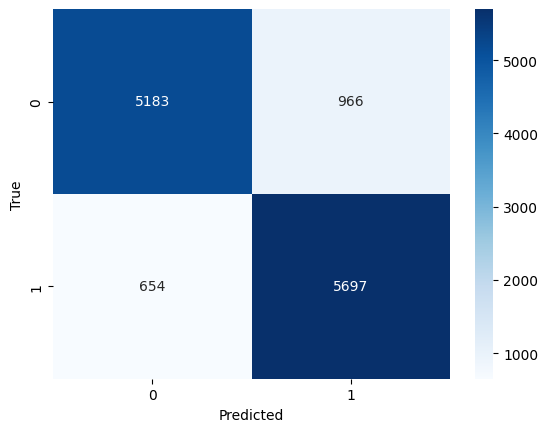

In [22]:
metricas(pred, y_test)

In [23]:
x_train, x_val = ngram_vectorize(X_train['review_es'],y_train, review_t['review_es'])
y_predic = model.predict(x_val)
y_predic_cat = np.where(y_predic>0.5,1,0)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [24]:
review_orig['sentimiento'] = y_predic
review_orig['sentimiento'] = review_orig['sentimiento'].map({1:'positivo',0:'negativo'},na_action=None)
review_orig.head()

,ID,review_es,sentimiento
0,60000,La mayor virtud de esta película es su existen...,negativo
1,60001,"No soy un experto cinéfilo, pero pocas veces m...",negativo
2,60002,Si no eres un incondicional del humor estilo T...,negativo
3,60003,"No sé qué está pasando, si la gente se deja ll...",negativo
4,60004,"Pero cuando amanece,y me quedo solo,siento en ...",negativo


In [25]:
entregable = pd.DataFrame({'ID': review_orig['ID'], 'sentimiento':review_orig['sentimiento']})

entregable.head()

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo


In [26]:
entregable.to_csv('voting_tfifd.csv', index=False)

In [28]:
import pickle
pickle.dump(model, open("Voting_model", "wb"))